# Amazon review dataset 2018
You can reach out the complete dataset at: http://deepyeti.ucsd.edu/jianmo/amazon/index.html

We are not in any position to offer any license on the data. Please cite the following paper if you use the data in any way:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [1]:
import json #the file is json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read json into a list
f = open('Luxury_Beauty.json', 'r')
dataset = []
for line in f:
    dataset.append(json.loads(line))

In [3]:
#convert list to pandas dataframe
dataset = pd.DataFrame(dataset)
dataset


,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,2.0,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN
1,5.0,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN
2,5.0,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
3,5.0,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
4,5.0,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
574623,5.0,NaN,True,"03 20, 2017",AHYJ78MVF4UQO,B01HIQEOLO,Lori Fox,Great color and I prefer shellac over gel,Five Stars,1489968000,NaN,NaN
574624,5.0,NaN,True,"10 26, 2016",A1L2RT7KBNK02K,B01HIQEOLO,Elena,Best shellac I have ever used. It doesn't tak...,Best shellac I have ever used,1477440000,NaN,NaN
574625,5.0,NaN,True,"09 30, 2016",A36MLXQX9WPPW9,B01HIQEOLO,Donna D. Harris,Great polish and beautiful color!!,Great polish!,1475193600,NaN,NaN
574626,1.0,2,True,"12 5, 2016",A23DRCOMC2RIXF,B01HJ2UY0W,Y.Y. Chen,"The perfume is good, but the spray head broke ...",Spray head broke off within a month,1480896000,"{'Size:': ' 1.7 Fluid Ounce', 'Color:': ' Multi'}",NaN


In [4]:
#check datatype
dataset.dtypes

overall           float64
vote               object
verified             bool
reviewTime         object
reviewerID         object
asin               object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
style              object
image              object
dtype: object

In [5]:
# we need just 3 columns here, overall score, review text and summary
#lets concatenate reviewtext and summary into a new column called final_review
dataset['final_review'] = dataset['reviewText'] + ' ' + dataset['summary']
#final_dataset 
dataset = dataset[['final_review', 'overall']]
dataset.head()

,final_review,overall
0,"I bought two of these 8.5 fl oz hand cream, an...",2.0
1,"Believe me, over the years I have tried many, ...",5.0
2,Great hand lotion Five Stars,5.0
3,This is the best for the severely dry skin on ...,5.0
4,The best non- oily hand cream ever. It heals o...,5.0


check for null values

In [6]:
#to get count of empty rows
dataset[dataset['final_review'].isna()].count()
#to get % of empty rows
dataset[dataset['final_review'].isna()].count()/len(dataset)

final_review    0.000000
overall         0.001001
dtype: float64

wow!!!!!!! 575 records dont have reviews but have a rating. Let's take them out

In [7]:
dataset = dataset.dropna()
#let's reset the index
dataset.reset_index(inplace = True)
del dataset['index']

In [8]:

#look at the destribution of data on our target variable
dataset['overall'].describe()
dataset['overall'].value_counts()/len(dataset)

5.0    0.664911
4.0    0.122699
1.0    0.087908
3.0    0.073112
2.0    0.051370
Name: overall, dtype: float64

lets reclassify the dataset to just 3 classes, positive (4 & 5), neg(1&2) and neutral(3).( pos 1, neu 0 and neg -1)


In [9]:
dataset['overall'] = dataset['overall'].apply(lambda x : 1 if x in (4,5) else -1 if x in (1,2) else 0)
dataset['overall'].value_counts()/len(dataset)

 1    0.787610
-1    0.139278
 0    0.073112
Name: overall, dtype: float64

to avoid a sampling bias we'll augment the reviews by oversampling. After oversampling we'll split the dataset into test and train using stratified sampling with the StratifiedShuffleSplit module in sklearn

lets check the distribution of data on the test data and see if the representation of the target variable is the close to the original sample

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
split= StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(dataset, dataset['overall']):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]
    

In [11]:
strat_test_set['overall'].value_counts()/len(strat_test_set)

 1    0.787607
-1    0.139281
 0    0.073111
Name: overall, dtype: float64

# now to start the main work!!!!!!

# Text augmentation to even out the trainset


In [12]:
#pip install textaugment

In [13]:
#import necessary nltk libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from textaugment import Wordnet, Translate


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ndukwead\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ndukwead\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\ndukwead\AppData\Roaming\Python\Python37\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [14]:
t=Wordnet()
#translate = Translate(src="en", to="en")
#test
sentence ='Hello, I have been so exhausted lately. I need to rest'
t.augment(sentence)
#translate.augment(sentence)

'hello, i have embody so exhausted lately. i want to rest'

In [15]:
#augment reviews with scores less than 4
augmented = pd.DataFrame()
for i in strat_train_set[strat_train_set['overall'] != 1].index:
    text_aug = t.augment(str(strat_train_set['final_review'][i]))
    augmented = augmented.append({'final_review':text_aug ,'overall': dataset['overall'][i]} , ignore_index=True)





In [18]:
#drop 60% of records with scores equal to 1 and add augmented to train set

part_na = round(strat_train_set[strat_train_set['overall'] == 1].shape[0]*0.6)
strat_train_set.head()
five_indices = strat_train_set[strat_train_set.overall == 1].index
random_indices = np.random.choice(five_indices, part_na, replace= False)
random_indices 


array([441135,  45129,  43578, ..., 118806, 398890, 364967], dtype=int64)

In [19]:
strat_train_set.drop(random_indices, inplace = True)
strat_train_set['overall'].value_counts()/len(strat_train_set)

 1    0.597316
-1    0.264066
 0    0.138618
Name: overall, dtype: float64

In [20]:
#append augmented to strat_train_set
strat_train_set = strat_train_set.append(augmented)
strat_train_set['overall'].value_counts()/len(strat_train_set)

 1.0    0.425838
-1.0    0.376515
 0.0    0.197647
Name: overall, dtype: float64

In [21]:
strat_test_set['overall'].value_counts()/len(strat_test_set)

 1    0.787607
-1    0.139281
 0    0.073111
Name: overall, dtype: float64

great!!!!!!!

# feature extraction
`basically we're going to get all the words (corpus) used in the final_reviews column of the dataset and convert them to features. Each of these reviews will then record the frequency of our features and their weights (i.e. the words) 
We're using the TF-IDF vectorizer in sklearn to achieve this
we can limit the number of features to a maximum using the most commonly occuring words`

In [22]:
#import machine learning related libraries
from sklearn.linear_model import LogisticRegression

#let's import our TF-IDF module
from sklearn.feature_extraction.text import TfidfVectorizer


In [23]:
vectorizer = TfidfVectorizer() #we can use to limit the number of features selected using max_features
X_test =vectorizer.fit_transform(strat_test_set['final_review'])


X_test.shape

(114811, 37507)

I didn't add the limit to the count vectorizer yet because I wanted to find out how many unique words were in the test dataset.
since there are just 37,583 possible features. let's use it like that. this is a sparse matrix, see below

In [24]:
X_test

<114811x37507 sparse matrix of type '<class 'numpy.float64'>'
	with 3511534 stored elements in Compressed Sparse Row format>

In [25]:
#transform X_train using test_shape
X_train = vectorizer.transform(strat_train_set['final_review'])


y_train = strat_train_set['overall']
y_test = strat_test_set['overall']

In [26]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,f1_score,precision_score,recall_score


model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)  
print('Accuracy', model.score(X_test, y_test))
print('F1', f1_score(y_test,model.predict(X_test), average="macro"))
print('Precision', precision_score(y_test, model.predict(X_test), average="macro"))
print('Recall', recall_score(y_test, model.predict(X_test), average="macro")) 

    

Accuracy 0.9023177221694786
F1 0.7684885399028758
Precision 0.7524705421853826
Recall 0.7872785793829294


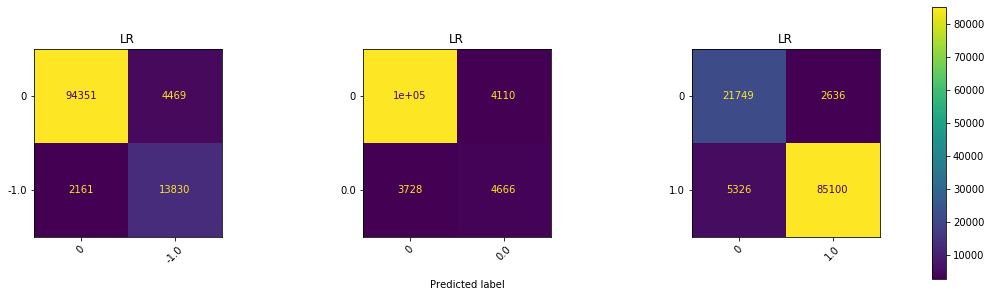

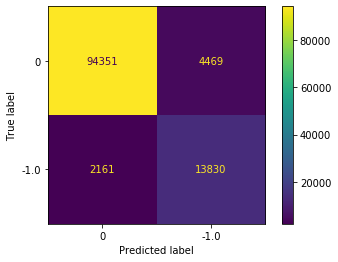

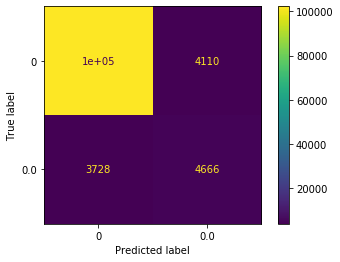

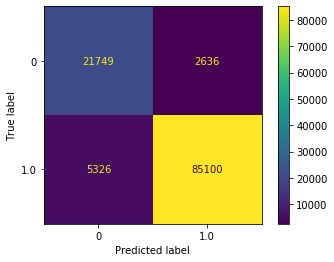

In [29]:

y_pred = model.predict(X_test)

cm = multilabel_confusion_matrix(y_test, y_pred)

f, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.40, hspace=0.1)
axes = axes.ravel()
for ind in range(3):
    cm_display = ConfusionMatrixDisplay(cm[ind], display_labels=[0, model.classes_[ind]]).plot()
    cm_display.plot(ax=axes[ind], xticks_rotation=45)
    cm_display.ax_.set_title("LR")
    cm_display.im_.colorbar.remove()
    cm_display.ax_.set_xlabel('')
    if i!=0:
        cm_display.ax_.set_ylabel('')
    
f.text(0.4, 0.1, 'Predicted label', ha='left')



f.colorbar(cm_display.im_, ax=axes)
